In [1]:
from typing import List, Literal

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.datasets import make_blobs

from utils import visualize_clusters

In [2]:
student_id = 994023037
np.random.seed(student_id)

### Load Data

In [3]:
X, y = make_blobs(
    n_samples=1000,
    n_features=8,
    centers=5,
    random_state=student_id
)

In [4]:
split_line = 0.8
q1 = int(np.ceil(X.shape[0] * split_line))
x_train, y_train = X[0:q1, :], y[0:q1]
x_test, y_test = X[q1:, :], y[q1:]

### Modeling

In [5]:
class KMeans :
    def __init__(
        self,
        n_clusters:int,
        centroid_init:List[Literal["kmeans++", "random"]] = "random",
        max_iter:int = 10,
    ) -> None:
        self.n_clusters = n_clusters
        self.centroid_init = centroid_init
        self.max_iter = max_iter
    
    @staticmethod
    def get_distance(x1, x2) :
        return np.linalg.norm(x1 - x2, axis=1)
    
    def _set_centroids(self) :
        if self.centroids is None : # initializing the centroids for the first time
            if self.centroid_init == "random" :
                chosen_centroids_index = np.random.randint(0, self.n_samples+1, size=self.n_clusters)
                self.centroids = self.X[chosen_centroids_index]
            elif self.centroid_init == "kmeans++" :
                first_centroid = self.X[np.random.randint(0, self.n_samples+1, size=1)]
                other_centroid_indexes = np.argsort(
                    KMeans.get_distance(
                        first_centroid,
                        self.X
                    )
                )[-1*(self.n_clusters-1):] # here we get the last (n_clusters-1) samples that are far from the first centroid
                self.centroids = np.concatenate(
                    [
                        first_centroid.reshape(1, self.n_features),
                        self.X[other_centroid_indexes]
                    ],
                    axis=0
                )
        else :
            for index in range(self.n_clusters) :
                new_centroid = self.X[self.clusters == index].mean(axis=0)
                self.centroids[index] = new_centroid

    def fit(self, x) :
        self.X = x
        self.n_samples, self.n_features = x.shape
        self.centroids = None 
        self.clusters = np.empty(shape=(self.n_samples,))

    def predict(self) :
        for _ in range(self.max_iter) :
            self._set_centroids()
            prev_clusters = self.clusters.copy()
            for index, sample in enumerate(self.X) :
                distance = self.get_distance(sample, self.centroids) # distance from eah centroid
                closest_centroid_index = np.argmin(distance)
                self.clusters[index] = closest_centroid_index
            if np.equal(prev_clusters, self.clusters).all() : # check if anything has changed since the last update
                break
    
    def evaluate(self, X,
        labels,
        method:List[Literal["Silhouette", "Calinski", "wcss"]]
    ) :
        '''
        Silhouette Score :  
            This metric ranges from -1 to 1, the higher the value, the better the clustering\n
            s(i) = (b(i) - a(i)) / max(a(i), b(i)) \n

        Calinski-Harabasz Index  :
            Measures ratio of dispersion between clusters to dispersion within clusters.    
            The higher the value, the better the clustering\n
            score = (trace(B) / (k - 1)) / (trace(W) / (n - k))\n

        WCSS :  
            Within-Cluster Sum of Squares (WCSS)  
            measures the sum of squared distances between each data point and the centroid of its assigned cluster\n
        '''
        if method == "Silhouette":
            silhouette_coeffs = []
            
            for i in range(len(X)):
                cluster_i = X[labels == labels[i]]
                a = np.sum(np.sqrt(np.sum((X[i] - cluster_i)**2, axis=1))) / (len(cluster_i) - 1)
                
                b = np.inf
                for j in range(self.n_clusters):
                    if j != labels[i]:
                        cluster_j = X[labels == j]
                        b = min(b, np.sum(np.sqrt(np.sum((X[i] - cluster_j)**2, axis=1))) / len(cluster_j))
                
                silhouette_coeffs.append((b - a) / max(a, b))
            
            return np.mean(silhouette_coeffs)
        
        elif method == "Calinski":            
            cluster_means = []
            for i in range(self.n_clusters):
                cluster_means.append(np.mean(X[labels == i], axis=0))
            
            overall_mean = np.mean(X, axis=0)
            
            B = 0
            for i in range(self.n_clusters):
                cluster_i = X[labels == i]
                B += len(cluster_i) * np.sum((cluster_means[i] - overall_mean)**2)
            
            W = 0
            for i in range(self.n_samples):
                W += np.sum((X[i] - cluster_means[int(labels[i])])**2)
            
            return (B / (self.n_clusters - 1)) / (W / (self.n_samples - self.n_clusters))
        
        elif method == "wcss":
            cluster_means = np.array([X[labels == label].mean(axis=0) for label in np.arange(self.n_clusters)])
            labels = labels.astype(int)
            wcss = np.sum(np.sum((X - cluster_means[labels])**2, axis=1))
            
            return wcss

In [6]:
model = KMeans(
    n_clusters=5,
    centroid_init="kmeans++",
    max_iter=10,
)
model.fit(X)
model.predict()

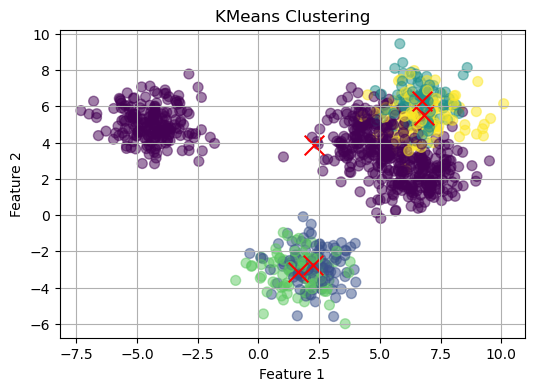

In [7]:
visualize_clusters(X, model.clusters, model.centroids)

### Evaluation

for evaluation, we use 3 methods<br>First one is **Silhouette score** which is a number between -1 to 1, higher score shows better performance  
the formula for calculating this metric is :  
`s(i) = (b(i) - a(i)) / max(a(i), b(i))`
<br></br>
The second method for evaluating the performance of the model is **Calinski-Harabasz Index**, like the previous metric, higher values  
shows better performance.  
the formula for calculating this metric is :  
`score = (trace(B) / (k - 1)) / (trace(W) / (n - k))`  
<br>
The last one is **WCSS**, which measures the sum of squared distances between each data point and the centroid of its assigned cluster.

In [8]:
model.evaluate(X, model.clusters, method="Silhouette")

0.3454499410760369

Silhouette score shows above average performance

In [9]:
model.evaluate(X, model.clusters, method="Calinski")

887.2677555789008

In [10]:
model.evaluate(X, model.clusters, method="wcss")

42000.74295621378

In [11]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

print(silhouette_score(X, model.clusters))
print(calinski_harabasz_score(X, model.clusters))

0.3454499410760369
887.2677555789007


the centroids are more clear if we use less features and centers :

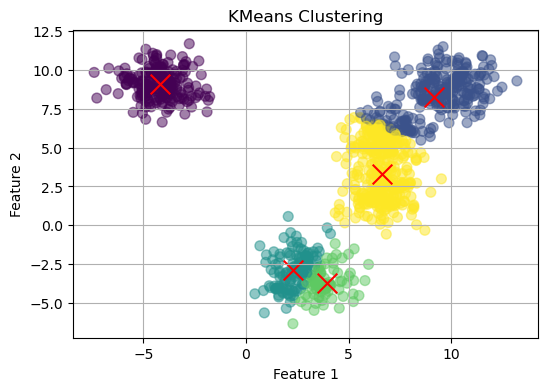

In [12]:
X_2, y_2 = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=5,
    random_state=student_id
)
model2 = KMeans(
    n_clusters=5,
    centroid_init="kmeans++",
    max_iter=10,
)
model2.fit(X_2)
model2.predict()

visualize_clusters(X_2, model2.clusters, model2.centroids)

### Test different values of n_clusters

In [13]:
# data = X
# n_clusters = [4, 5, 6, 7]

data = X_2
n_clusters = [3, 4, 5, 6]

In [14]:
results = []
for n in n_clusters :
    model = KMeans(
        n_clusters=n,
        centroid_init="kmeans++",
        max_iter=10,
    )
    model.fit(data)
    model.predict()
    results.append([model.clusters, model.centroids])

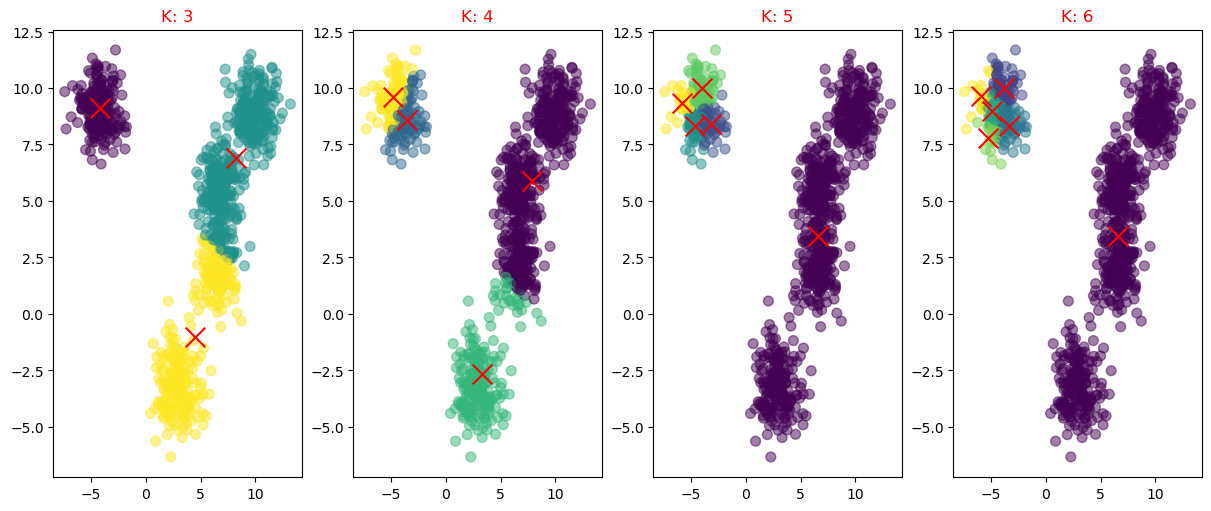

In [15]:
fig, ax = plt.subplots(1, len(n_clusters), figsize=(12, 5), layout="constrained")
for index, result in zip(range(len(n_clusters)), results) :
    labels, centroid = result
    ax[index].scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
    ax[index].scatter(centroid[:, 0], centroid[:, 1], c='red', marker='x', s=200)
    ax[index].set_title(f'K: {n_clusters[index]}', color="red")
    # ax[index].grid(True)

### Choosing the best value for K

for that, we are going to use **elbow method** 

In [16]:
data = X_2

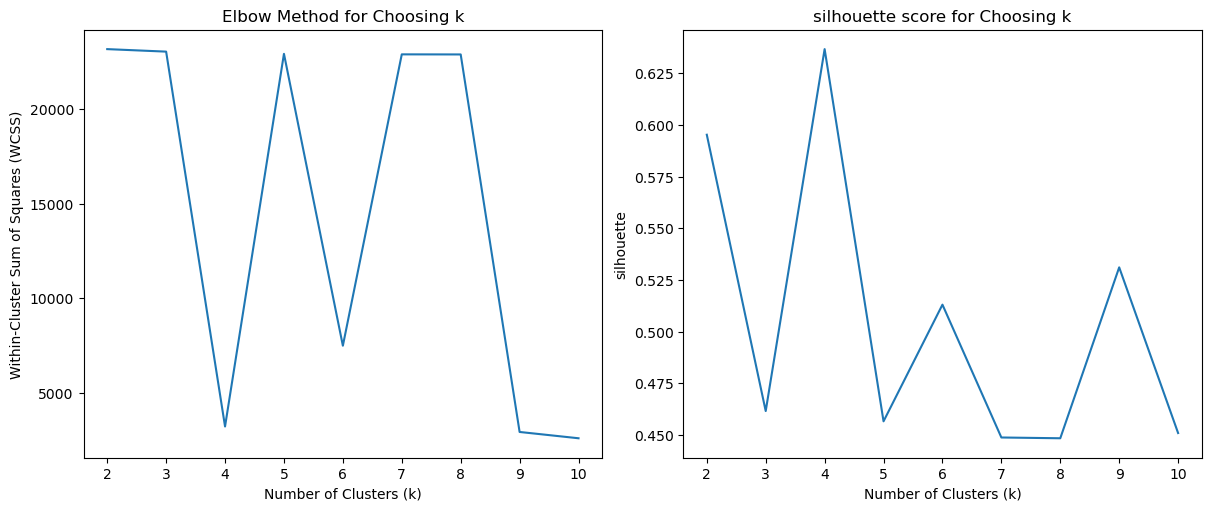

In [40]:
wcss_values = []
silhouette_values = []

for k in range(2, 11):
    model = KMeans(
        n_clusters=k,
        centroid_init="kmeans++",
        max_iter=10,
    )
    model.fit(data)
    model.predict()
    wcss_values.append(model.evaluate(data, model.clusters, method="wcss"))
    silhouette_values.append(model.evaluate(data, model.clusters, method="Silhouette"))


# Plot WCSS against k
fig, ax = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

ax[0].plot(range(2, 11), wcss_values)
ax[0].set_xlabel("Number of Clusters (k)")
ax[0].set_ylabel("Within-Cluster Sum of Squares (WCSS)")
ax[0].set_title("Elbow Method for Choosing k")

ax[1].plot(range(2, 11), silhouette_values)
ax[1].set_xlabel("Number of Clusters (k)")
ax[1].set_ylabel("silhouette")
ax[1].set_title("silhouette score for Choosing k")

plt.show()

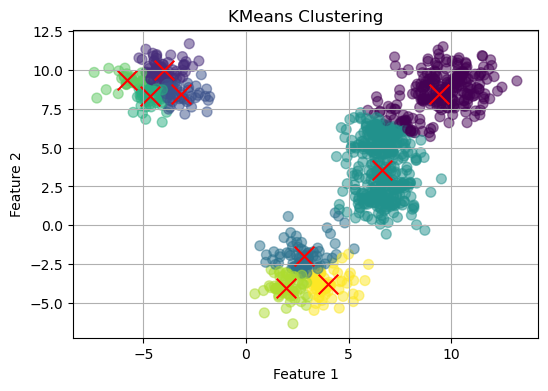

In [27]:
model_k9 = KMeans(n_clusters=9, centroid_init="kmeans++")
model_k9.fit(data)
model_k9.predict()

visualize_clusters(data, model_k9.clusters, model_k9.centroids)

In [28]:
model_k9.evaluate(data, model_k8.clusters, method="Silhouette")

0.5633234537590662

after checking the result of different values of K using the elbow method, we can see that the Silhouette score is better than before  
and also the plot shows better results than previous one.  
so k=9 seams like a good choice for number of clusters

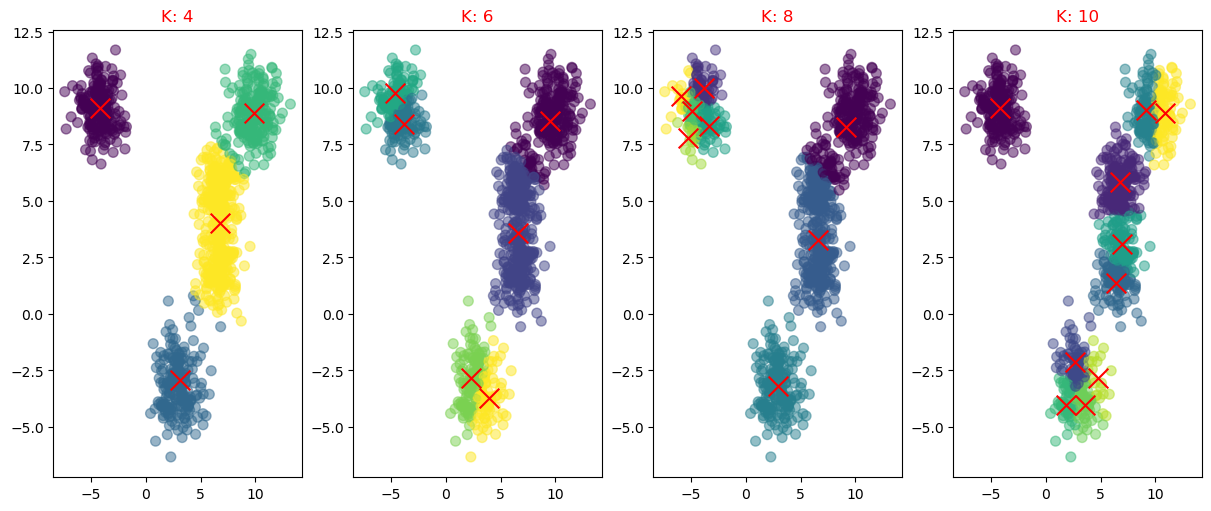

In [32]:
n_clusters = [4, 6, 8, 10]
results = []
for n in n_clusters :
    model = KMeans(
        n_clusters=n,
        centroid_init="kmeans++",
        max_iter=10,
    )
    model.fit(data)
    model.predict()
    results.append([model.clusters, model.centroids])

fig, ax = plt.subplots(1, len(n_clusters), figsize=(12, 5), layout="constrained")
for index, result in zip(range(len(n_clusters)), results) :
    labels, centroid = result
    ax[index].scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
    ax[index].scatter(centroid[:, 0], centroid[:, 1], c='red', marker='x', s=200)
    ax[index].set_title(f'K: {n_clusters[index]}', color="red")
    # ax[index].grid(True)